In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from tqdm import tqdm
from scipy.signal import argrelextrema
from scipy.signal import find_peaks

rcParams['figure.figsize'] = 12,7
rcParams['font.size'] = 11
color_map = ["tab:blue", "tab:cyan", "tab:red", "tab:green"]

# Fear model by age with face and online contacts

Let's consider $K$ age classes, each with population $N_i$ ($i = 1,...,K$), such that $\sum_i N_i = N$.
The equations of the model are the following:

$$
\begin{aligned}
 \frac{dS_i}{dt} = -\beta S_i \sum_{j} k_{ij}\frac{I_j}{N_j} - \beta_i^F S_i \left[ \sum_{j} k_{ij}\frac{I_j}{N_j} + \alpha  \sum_{j} (k_{ij} + \gamma M_{ij}) \frac{S_j^F}{N_j} \right] + \mu_F S_i^F \sum_{j} (k_{ij} + \gamma M_{ij}) \frac{(S_j + R_j)}{N_j}
\end{aligned}
$$
$$
\begin{aligned}
 \frac{dS_i^F}{dt} = - r_{\beta} \beta S_i^F \sum_{j} k_{ij}\frac{I_j}{N_j} + \beta_i^F S_i \left[ \sum_{j} k_{ij}\frac{I_j}{N_j} + \alpha  \sum_{j} (k_{ij} + \gamma M_{ij}) \frac{S_j^F}{N_j} \right] - \mu_F S_i^F \sum_{j} (k_{ij} + \gamma M_{ij}) \frac{(S_j + R_j)}{N_j}
\end{aligned}
$$
$$
\begin{aligned}
 \frac{dI_i}{dt} = - \mu I_i +\beta S_i \sum_{j} k_{ij}\frac{I_j}{N_j} + r_{\beta} \beta S_i^F \sum_{j} k_{ij}\frac{I_j}{N_j}
\end{aligned}
$$
$$
\begin{aligned}
 \frac{dR_i}{dt} = \mu I_i 
\end{aligned}
$$

The additional ingridient is the face-to-face contact matrix $k_{ij}$ and the "online" contact matrix $M_{ij}$. The parameter $\gamma$ can assume values between $0$ and $1$ and measures how one can get feared online with respect to in person contacts.

In [2]:
def deterministic_simulation(R_0, beta_F, r_b, mu, mu_F, alpha, gamma, R0, S_F0, I0, N, T, k, M, T_switch, mod, flag):
    
    # R_F is a vector this time
    
    dt = 0.1
    q = int(T/dt)
    t_switch = int(T_switch/dt)
    time = np.arange(q)*dt
    
    nc = k.shape[0]
 
    lambd_max = np.max(np.linalg.eigvals(k))
    
    beta = mu*R_0/lambd_max
    #beta_F = mu_F*R_F/alpha
    #R_0 = beta/mu
    #R_F = beta_F*alpha/mu_F
    N_tot = sum(N)
    
    S = np.zeros((nc, q))
    S_F = np.zeros((nc, q))
    I = np.zeros((nc, q))
    R = np.zeros((nc, q))

    for i in range(nc):
        S[i,0] = N[i] - R0[i] - S_F0[i] - I0[i]
        S_F[i,0] = S_F0[i]
        I[i,0] = I0[i]
        R[i,0] = R0[i]
        
    for t in range(q-1):
        
        # at t_switch the model parameters change 
        if t == t_switch:
            
            beta_F, alpha, k = switch_behaviour(flag, beta_F, alpha, k, mod)
            
        for i in range(nc):
            
            S_to_I = beta*S[i,t]*np.dot(k[i], I[:,t]/N)
            S_to_SF = beta_F[i]*S[i,t]*(np.dot(k[i], I[:,t]/N) + alpha*np.dot(k[i] + gamma*M[i], S_F[:,t]/N))
            SF_to_S = mu_F*S_F[i,t]*np.dot(k[i] + gamma*M[i], (S[:,t]+R[:,t])/N)
            SF_to_I = r_b*beta*S_F[i,t]*np.dot(k[i], I[:,t]/N)
            I_to_R = mu*I[i,t]

            
            S[i,t+1] = S[i,t] + (-S_to_I - S_to_SF + SF_to_S)*dt
            
            S_F[i,t+1] = S_F[i,t] + (-SF_to_I + S_to_SF - SF_to_S)*dt

            I[i,t+1] = I[i,t] + (-I_to_R + S_to_I + SF_to_I)*dt
            
            R[i,t+1] = R[i,t] + (I_to_R)*dt
    
    # this is just to reset the changes done in the variables
    beta_F, alpha, k = switch_behaviour(flag, beta_F, alpha, k, 1/mod)
    
    return time, S, S_F, I, R, R[:, -1]/N

## Possible interventions:
1. boost in fear for old people
2. online awareness/sensibilization campaign
3. isolating the elder class

In [3]:
# function to modify some of the model parameters, depending on the flag
def switch_behaviour(flag, beta_F, alpha, k, mod):
    if flag == 1: #measure 1
        beta_F[-1] *= mod
    elif flag == 2: #measure 2
        alpha *= mod
    elif flag == 3: #measure 3
        k = cut_contacts(k, mod)
    else:
        raise Exception("Sorry, select a meaningful flag")
    
    return beta_F, alpha, k

In [4]:
# function to decrease the contacts of the elder class (measure 3)
def cut_contacts(k, mod): # mod needs to be the retained fraction of contacts
    k_new = np.copy(k)
    n = k_new.shape[0]
    for i in range(n-1):
        k_new[n-1, i] = k_new[n-1, i]*mod
        k_new[i, n-1] = k_new[i, n-1]*mod
    k_new[n-1, n-1] = k_new[n-1, n-1]*mod
    
    return k_new

In [5]:
def find_end(infected):
    a = np.where(abs(infected - 0.8) < 0.2)
    a = np.diff(a)
    return np.max(a[a>1]).item()/10

## Simulation example

$R_{0} = 2.5$  	->	realistic value for an epidemic

$\mu = 1/10$	->	10 days are the average duration for the disease

$\mu_F = 1/7$ 	->	7 days are the average duration for fear

$r_\beta = 0.3$	->	protection given by masks

$\alpha = 0.05$	->	value taken from the reference paper

$\gamma = 0.8$		->	assuming online contacts are less important than the face-to-face ones

$\beta_F= 1.5$

[[ 7.39677519  1.65767433  5.56867511  1.95565292  1.12545173]
 [ 1.03011503 14.21852772  6.465301    3.37043051  0.88541503]
 [ 1.39898044  2.61373768  9.66429715  3.22466939  1.58484117]
 [ 0.99790082  2.76754358  6.54969437  4.20922947  2.34146693]
 [ 0.53794872  0.68104277  3.01536569  2.19334239  2.32233697]]
[[ 0.782     1.104     0.805     0.1242    0.02484 ]
 [ 0.0149   30.396     2.6075    0.20115   0.020115]
 [ 0.186     8.928    45.57      1.674     0.2511  ]
 [ 0.0925    4.44      6.475     4.995     0.124875]
 [ 0.101     2.424     5.3025    2.2725    1.3635  ]]
[[ 7.94417519  2.43047433  6.13217511  2.04259292  1.14283973]
 [ 1.04054503 35.49572772  8.290551    3.51123551  0.89949553]
 [ 1.52918044  8.86333768 41.56329715  4.39646939  1.76061117]
 [ 1.06265082  5.87554358 11.08219437  7.70572947  2.42887943]
 [ 0.60864872  2.37784277  6.72711569  3.78409239  3.27678697]]


<ipython-input-14-fc4ad8cbd9ea>:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+lab)
<ipython-input-14-fc4ad8cbd9ea>:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+lab)
<ipython-input-14-fc4ad8cbd9ea>:61: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


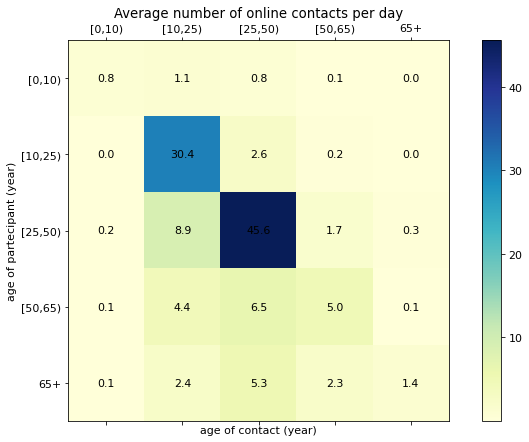

In [14]:
# model parameters

R_0 = 2.5 #1.0 critical
mu = 1/10
beta_F = np.array([3, 3, 3, 3, 3]) #20/7 critical
mu_F = 1/7
r_b = 0.3
alpha = 0.05
gamma = 0.7

R0 = [0, 0, 0, 0, 0]                  # initially recovered
S_F0 = [0, 0, 1, 0, 0]                # initially feared
I0 = [0, 0, 0, 0, 0]                  # initially infected

N_tot = 60*10**6                      # Italian population
T = 1000                              # simulation time
T_switch = 50

#face-to-face contact matrix
k = np.loadtxt(open("social_contact_matrix.csv", "rb"), delimiter=",", skiprows=1)

classes = np.array([0.092, 0.149, 0.372, 0.185, 0.202]) # population Italy 2008
N_classes = N_tot*classes 

#online contact matrix
avg_friends = np.array([100, 300, 250, 75, 30])
#avg_friends = np.array([20, 250, 250, 75, 30])
daily_use = np.array([0.1, 0.8, 0.7, 0.6, 0.45])
M = np.zeros((5,5))

for i in range(0,5):
    M[i] = avg_friends*daily_use*N_classes[i]/N_tot

clusters = np.ones((5,5))
clusters[0] = [0.85, 0.05, 0.05, 0.03, 0.02]
clusters[1] = [0.01, 0.85, 0.1, 0.03, 0.01]
clusters[2] = [0.05, 0.1, 0.7, 0.1, 0.05]
clusters[3] = [0.05, 0.1, 0.2, 0.6, 0.05]
clusters[4] = [0.05, 0.05, 0.15, 0.25, 0.5]

np.set_printoptions(suppress=True)

M = np.multiply(M, clusters, dtype = 'float')
#print(M)

lab = ['[0,10)', '[10,25)', '[25,50)', '[50,65)', '65+']

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(M, cmap='YlGnBu')
fig.colorbar(cax) #ticks=[0,3,6,9,12,15])
ax.set_title('Average number of online contacts per day')
ax.set_xlabel('age of contact (year)')
ax.set_ylabel('age of partecipant (year)')
ax.set_xticklabels(['']+lab)
ax.set_yticklabels(['']+lab)

for (i, j), z in np.ndenumerate(M):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')

fig.show()

#p_ospedal = 0.068

print(k)
print(M)
print((k + gamma*M))

#print(cut_contacts(k, 0.5))

In [15]:
flag = 1 # varying alpha in this case
mod = 1 # multiplicative modifier
time, S, S_F, I, R, r_inf = deterministic_simulation(R_0, beta_F, r_b, mu, mu_F, alpha, gamma, R0, S_F0, I0, N_classes, T, k, M, T_switch, mod, flag)

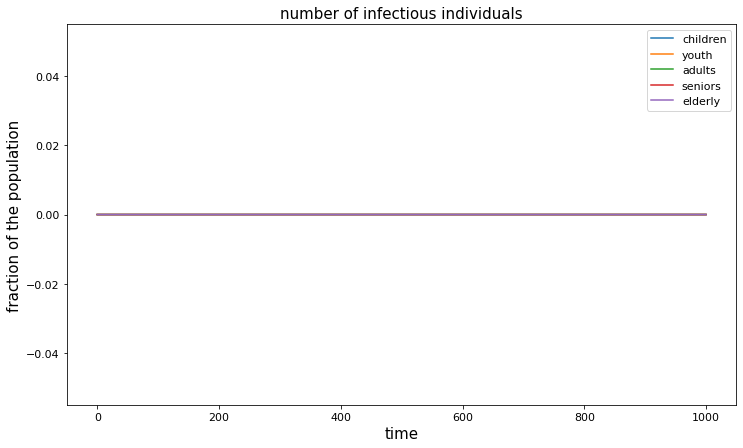

In [16]:
plt.plot(time,I[0]/N_classes[0], label='children')
plt.plot(time,I[1]/N_classes[1], label='youth')
plt.plot(time,I[2]/N_classes[2], label='adults')
plt.plot(time,I[3]/N_classes[3], label='seniors')
plt.plot(time,I[4]/N_classes[4], label='elderly')
plt.xlabel("time", fontsize = 15)
plt.ylabel("fraction of the population", fontsize = 15)
plt.title("number of infectious individuals", fontsize = 15)
plt.vlines(T_switch, 0, np.max(I[1]/N_classes[1]), colors = 'r', linestyles = 'dashed')
plt.legend()

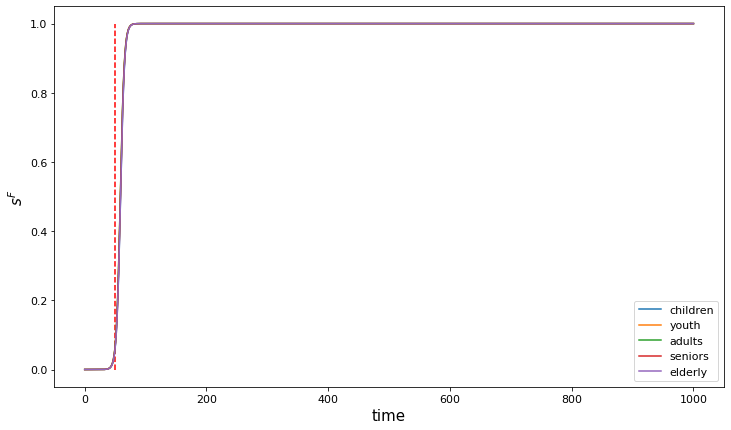

In [17]:
plt.plot(time,S_F[0]/N_classes[0], label='children')
plt.plot(time,S_F[1]/N_classes[1], label='youth')
plt.plot(time,S_F[2]/N_classes[2], label='adults')
plt.plot(time,S_F[3]/N_classes[3], label='seniors')
plt.plot(time,S_F[4]/N_classes[4], label='elderly')
plt.xlabel("time", fontsize = 15)
plt.ylabel(r"$s^F$", fontsize = 15)
plt.vlines(T_switch, 0, np.max(S_F[0]/N_classes[0]), colors = 'r', linestyles = 'dashed')
plt.legend()

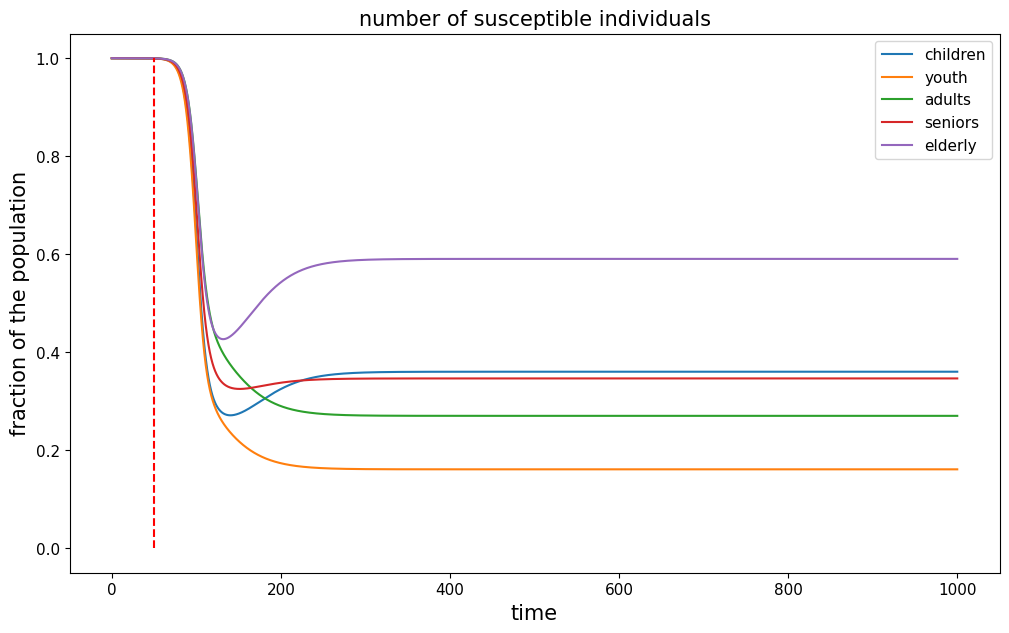

In [31]:
plt.plot(time,S[0]/N_classes[0], label='children')
plt.plot(time,S[1]/N_classes[1], label='youth')
plt.plot(time,S[2]/N_classes[2], label='adults')
plt.plot(time,S[3]/N_classes[3], label='seniors')
plt.plot(time,S[4]/N_classes[4], label='elderly')
plt.xlabel("time", fontsize = 15)
plt.ylabel("fraction of the population", fontsize = 15)
plt.title("number of susceptible individuals", fontsize = 15)
plt.vlines(T_switch, 0, np.max(S[0]/N_classes[0]), colors = 'r', linestyles = 'dashed')
plt.legend()

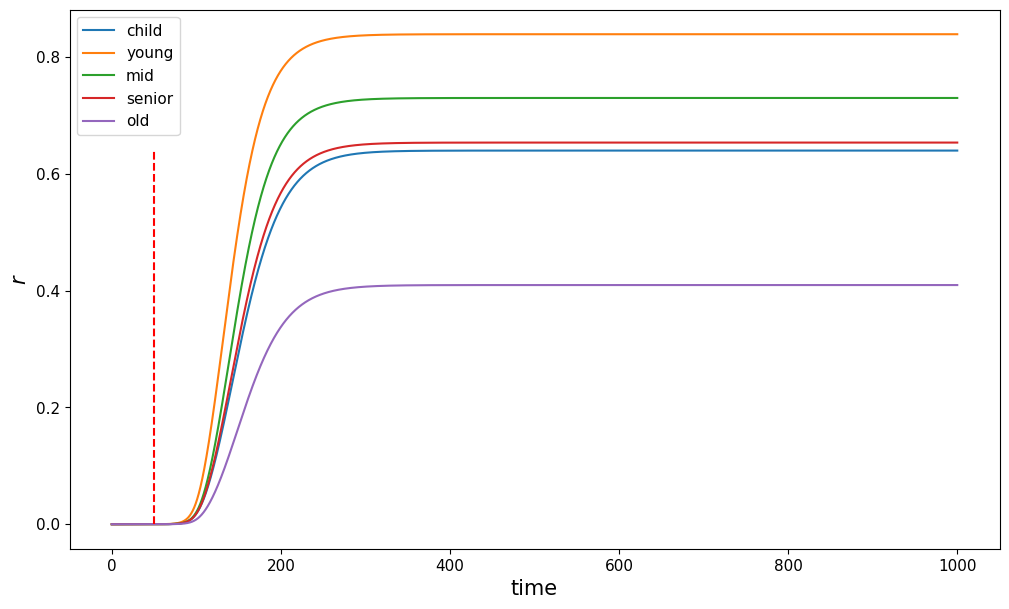

In [11]:
plt.plot(time,R[0]/N_classes[0], label='children')
plt.plot(time,R[1]/N_classes[1], label='youth')
plt.plot(time,R[2]/N_classes[2], label='adults')
plt.plot(time,R[3]/N_classes[3], label='seniors')
plt.plot(time,R[4]/N_classes[4], label='elderly')
plt.xlabel("time", fontsize = 15)
plt.ylabel(r"$r$", fontsize = 15)
plt.vlines(T_switch, 0, np.max(R[0]/N_classes[0]), colors = 'r', linestyles = 'dashed')
plt.legend()

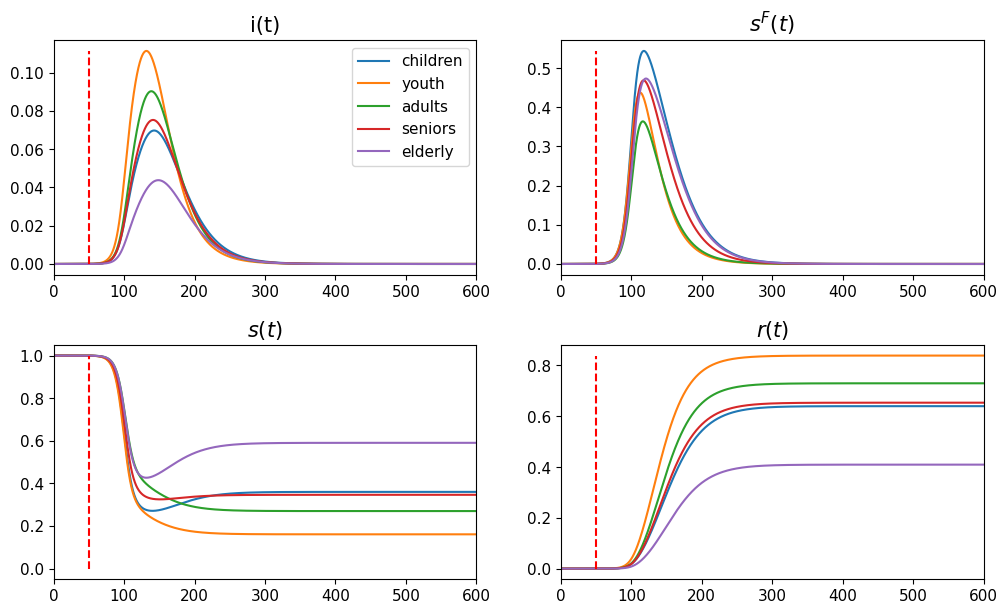

In [32]:
figure, axis = plt.subplots(2, 2)
plt.setp(axis, xlim=[0,600])
plt.subplots_adjust(hspace=0.3)

axis[0,0].plot(time,I[0]/N_classes[0], label='children')
axis[0,0].plot(time,I[1]/N_classes[1], label='youth')
axis[0,0].plot(time,I[2]/N_classes[2], label='adults')
axis[0,0].plot(time,I[3]/N_classes[3], label='seniors')
axis[0,0].plot(time,I[4]/N_classes[4], label='elderly')
axis[0,0].set_title("i(t)", fontsize = 15)
axis[0,0].vlines(T_switch, 0, np.max(I[1]/N_classes[1]), colors = 'r', linestyles = 'dashed')
axis[0,0].legend()

axis[0,1].plot(time,S_F[0]/N_classes[0], label='children')
axis[0,1].plot(time,S_F[1]/N_classes[1], label='youth')
axis[0,1].plot(time,S_F[2]/N_classes[2], label='adults')
axis[0,1].plot(time,S_F[3]/N_classes[3], label='seniors')
axis[0,1].plot(time,S_F[4]/N_classes[4], label='elderly')
axis[0,1].set_title(r"$s^F (t)$", fontsize = 15)
axis[0,1].vlines(T_switch, 0, np.max(S_F[0]/N_classes[0]), colors = 'r', linestyles = 'dashed')

axis[1,0].plot(time,S[0]/N_classes[0], label='children')
axis[1,0].plot(time,S[1]/N_classes[1], label='youth')
axis[1,0].plot(time,S[2]/N_classes[2], label='adults')
axis[1,0].plot(time,S[3]/N_classes[3], label='seniors')
axis[1,0].plot(time,S[4]/N_classes[4], label='elderly')
axis[1,0].set_title(r"$s (t)$", fontsize = 15)
axis[1,0].vlines(T_switch, 0, np.max(S[0]/N_classes[0]), colors = 'r', linestyles = 'dashed')

axis[1,1].plot(time,R[0]/N_classes[0], label='children')
axis[1,1].plot(time,R[1]/N_classes[1], label='youth')
axis[1,1].plot(time,R[2]/N_classes[2], label='adults')
axis[1,1].plot(time,R[3]/N_classes[3], label='seniors')
axis[1,1].plot(time,R[4]/N_classes[4], label='elderly')
axis[1,1].set_title(r"$r (t)$", fontsize = 15)
axis[1,1].vlines(T_switch, 0, np.max(R[1]/N_classes[1]), colors = 'r', linestyles = 'dashed')

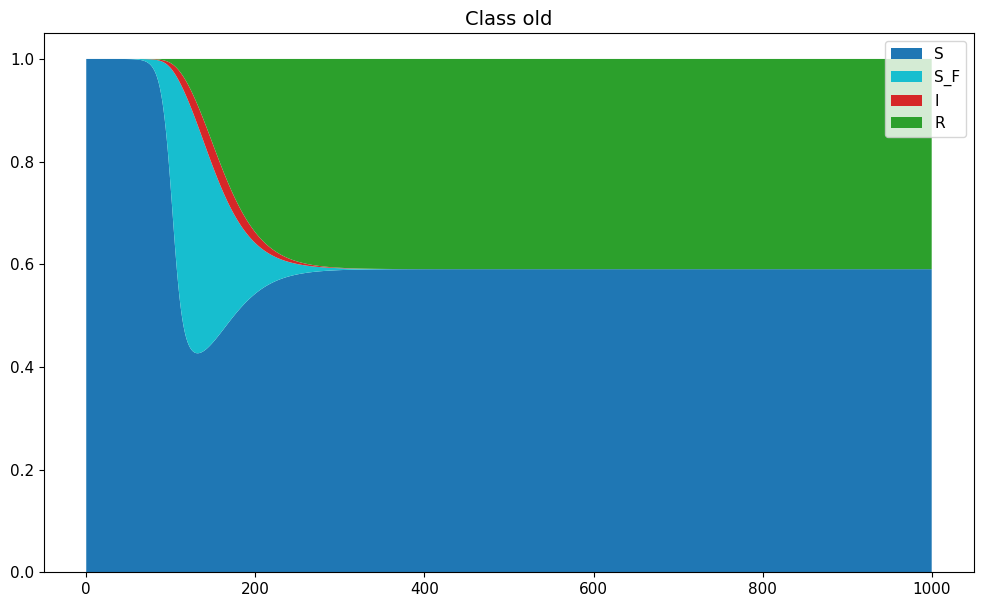

In [12]:
# stackplot of the old class just as example
cs = 4 # old

plt.stackplot(time, S[cs]/N_classes[cs], S_F[cs]/N_classes[cs], I[cs]/N_classes[cs], R[cs]/N_classes[cs], labels=['S', 'S_F', 'I', 'R'], colors=color_map)
plt.title('Class old', fontsize=14)
plt.legend()

### 1. Boost in fear for the 65+ class

In [13]:
flag = 1
T = 2000
mod_ = np.linspace(1, 4, 50)
zr = np.zeros((50, 5))
h_peak = np.zeros((50,5))
time_ext = np.zeros((50,5))

for i in tqdm(range(mod_.shape[0])):
    row = deterministic_simulation(R_0, beta_F, r_b, mu, mu_F, alpha, gamma, R0, S_F0, I0, N_classes, T, k, M, T_switch, mod_[i], flag)
    zr[i] = row[5]
    
    for j in range(5):
        time_ext[i, j] = find_end(row[3][j])
        h_peak[i, j] = max(find_peaks(row[3][j]/N_classes[j], height= 0)[1]['peak_heights'])

100%|██████████| 50/50 [03:34<00:00,  4.29s/it]


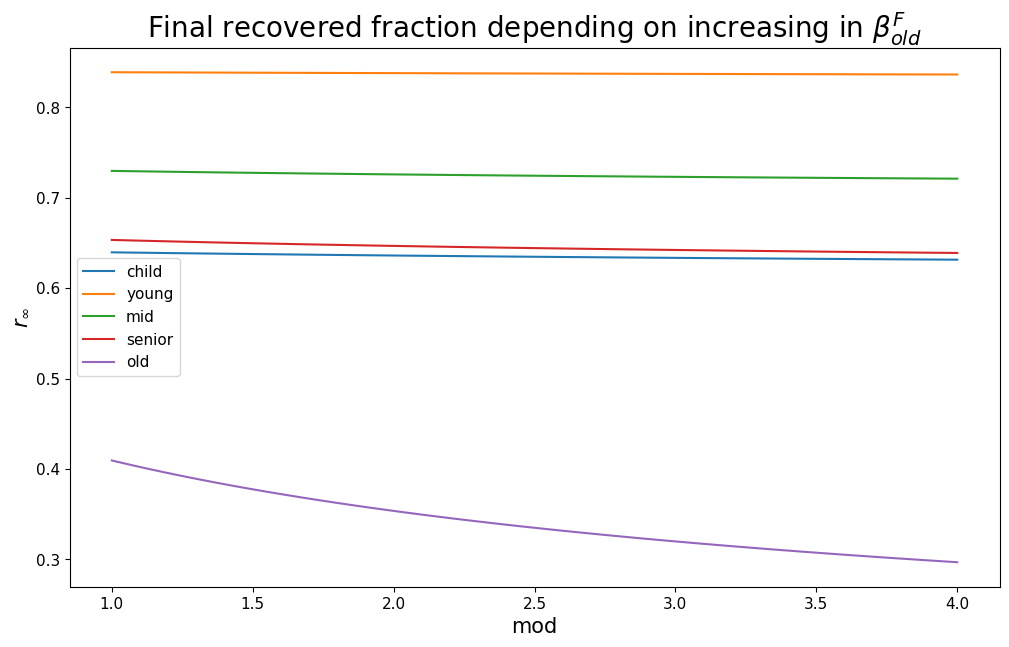

In [14]:
plt.plot(mod_, zr[:,0], label = 'child')
plt.plot(mod_, zr[:,1], label = 'young')
plt.plot(mod_, zr[:,2], label = 'mid')
plt.plot(mod_, zr[:,3], label = 'senior')
plt.plot(mod_, zr[:,4], label = 'old')
plt.xlabel(r'mod', fontsize = 15)
plt.ylabel(r'$r_{\infty}$', fontsize = 15)
plt.title(r'Final recovered fraction depending on increasing in $\beta_{old}^F$', fontsize = 20)
#plt.xlim(1,max_gamma)
plt.legend()

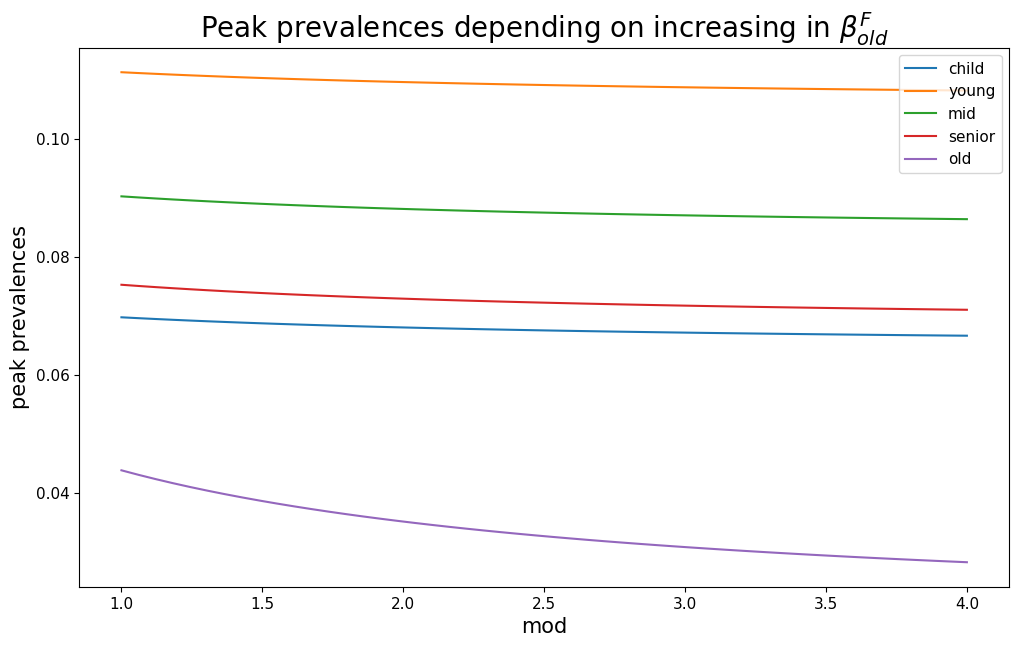

In [15]:
plt.plot(mod_, h_peak[:,0], label = 'child')
plt.plot(mod_, h_peak[:,1], label = 'young')
plt.plot(mod_, h_peak[:,2], label = 'mid')
plt.plot(mod_, h_peak[:,3], label = 'senior')
plt.plot(mod_, h_peak[:,4], label = 'old')
plt.xlabel(r'mod', fontsize = 15)
plt.ylabel(r'peak prevalences', fontsize = 15)
plt.title(r'Peak prevalences depending on increasing in $\beta_{old}^F$', fontsize = 20)
#plt.xlim(1,max_gamma)
plt.legend()

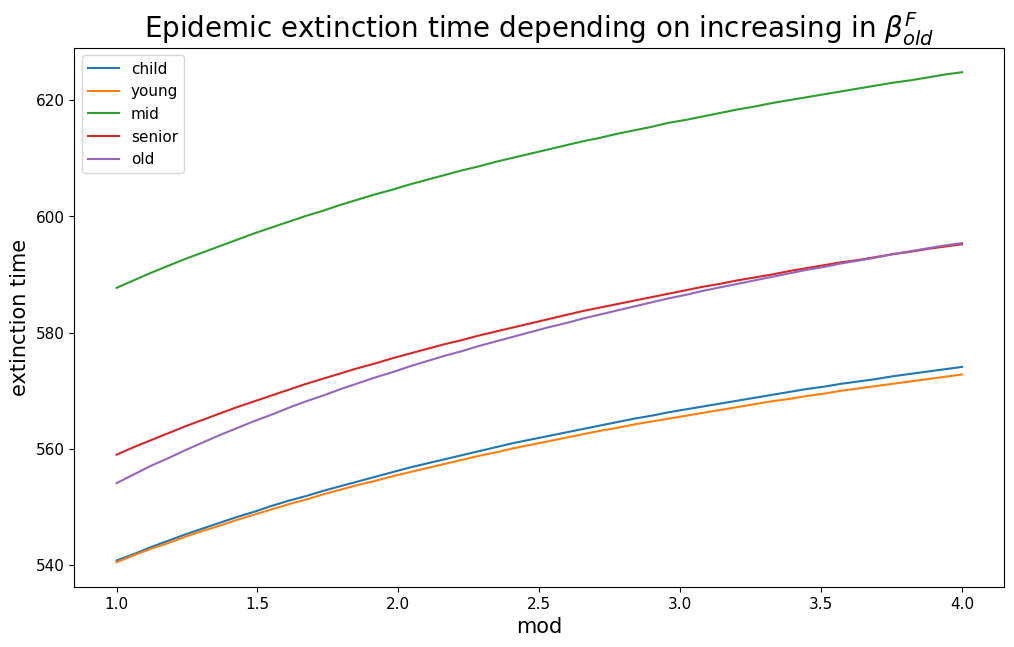

In [16]:
plt.plot(mod_, time_ext[:,0], label = 'child')
plt.plot(mod_, time_ext[:,1], label = 'young')
plt.plot(mod_, time_ext[:,2], label = 'mid')
plt.plot(mod_, time_ext[:,3], label = 'senior')
plt.plot(mod_, time_ext[:,4], label = 'old')
plt.xlabel(r'mod', fontsize = 15)
plt.ylabel(r'extinction time', fontsize = 15)
plt.title(r'Epidemic extinction time depending on increasing in $\beta_{old}^F$', fontsize = 20)
#plt.xlim(1,max_gamma)
plt.legend()

### 2. Online sensibilization campaign
General increase of fear got from other feared (maybe social effect, sensibilization campaign)

In [17]:
flag = 2
T = 2000
mod_ = np.linspace(1, 3, 50)
zr = np.zeros((50, 5))
h_peak = np.zeros((50,5))
time_ext = np.zeros((50,5))

for i in tqdm(range(mod_.shape[0])):
    row = deterministic_simulation(R_0, beta_F, r_b, mu, mu_F, alpha, gamma, R0, S_F0, I0, N_classes, T, k, M, T_switch, mod_[i], flag)
    zr[i] = row[5]

    for j in range(5):
        time_ext[i, j] = find_end(row[3][j])
        h_peak[i, j] = max(find_peaks(row[3][j]/N_classes[j], height= 0)[1]['peak_heights'])

100%|██████████| 50/50 [03:34<00:00,  4.29s/it]


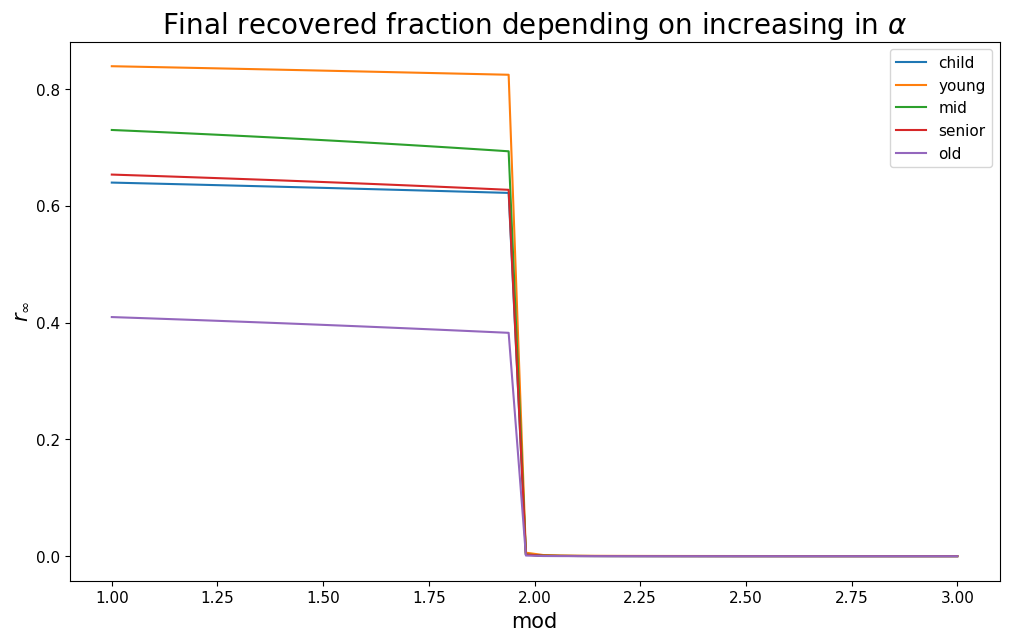

In [18]:
plt.plot(mod_, zr[:,0], label = 'child')
plt.plot(mod_, zr[:,1], label = 'young')
plt.plot(mod_, zr[:,2], label = 'mid')
plt.plot(mod_, zr[:,3], label = 'senior')
plt.plot(mod_, zr[:,4], label = 'old')
plt.xlabel(r'mod', fontsize = 15)
plt.ylabel(r'$r_{\infty}$', fontsize = 15)
plt.title(r'Final recovered fraction depending on increasing in $\alpha$', fontsize = 20)
#plt.xlim(1,max_gamma)
plt.legend()

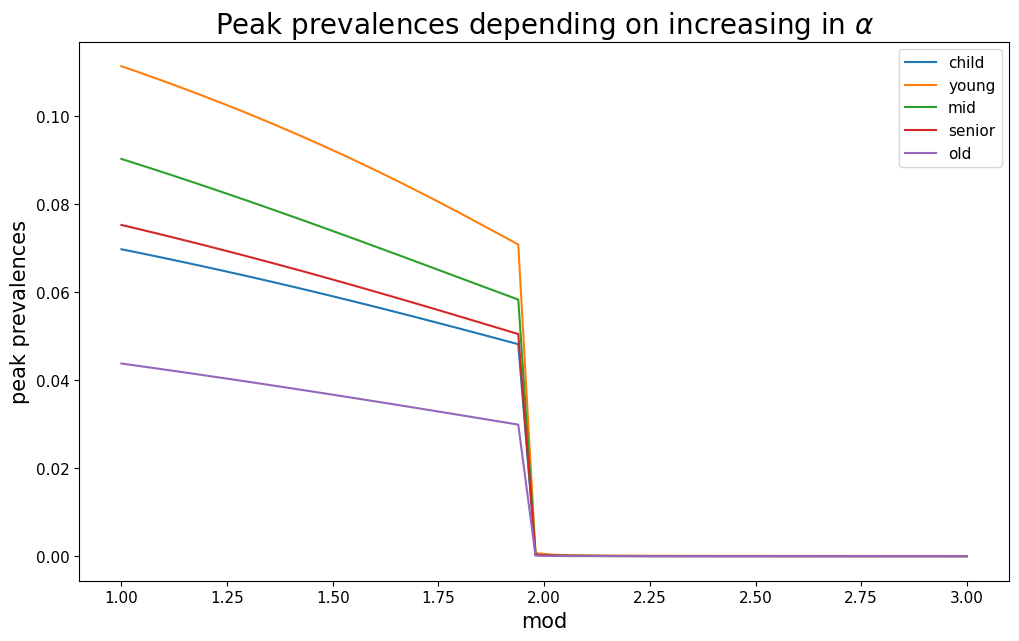

In [19]:
plt.plot(mod_, h_peak[:,0], label = 'child')
plt.plot(mod_, h_peak[:,1], label = 'young')
plt.plot(mod_, h_peak[:,2], label = 'mid')
plt.plot(mod_, h_peak[:,3], label = 'senior')
plt.plot(mod_, h_peak[:,4], label = 'old')
plt.xlabel(r'mod', fontsize = 15)
plt.ylabel(r'peak prevalences', fontsize = 15)
plt.title(r'Peak prevalences depending on increasing in $\alpha$', fontsize = 20)
#plt.xlim(1,max_gamma)
plt.legend()

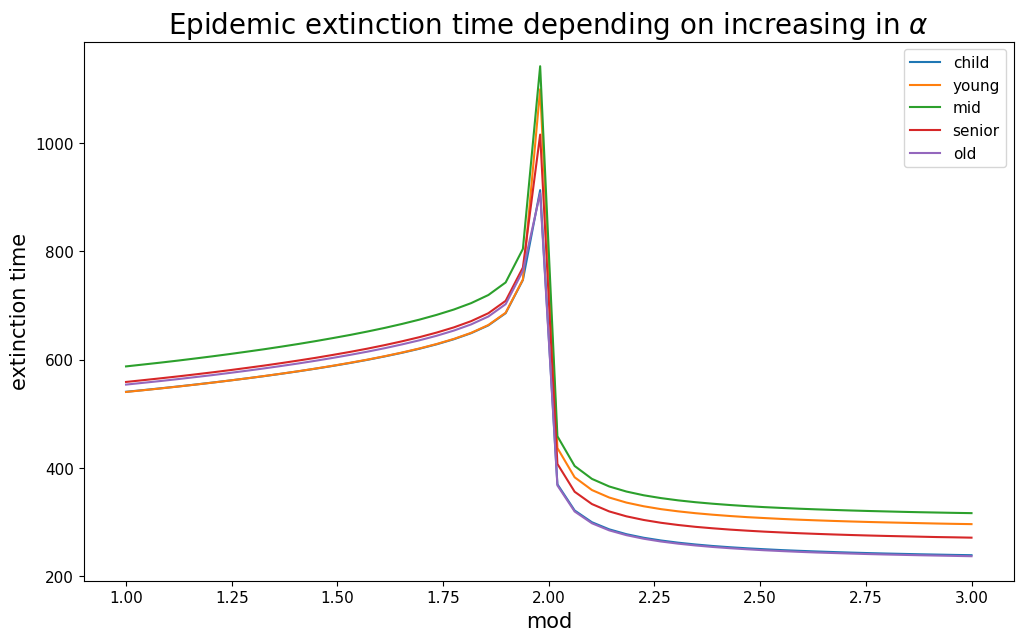

In [20]:
plt.plot(mod_, time_ext[:,0], label = 'child')
plt.plot(mod_, time_ext[:,1], label = 'young')
plt.plot(mod_, time_ext[:,2], label = 'mid')
plt.plot(mod_, time_ext[:,3], label = 'senior')
plt.plot(mod_, time_ext[:,4], label = 'old')
plt.xlabel(r'mod', fontsize = 15)
plt.ylabel(r'extinction time', fontsize = 15)
plt.title(r'Epidemic extinction time depending on increasing in $\alpha$', fontsize = 20)
#plt.xlim(1,max_gamma)
plt.legend()

### 3. Cutting old people contatcs

In [21]:
flag = 3
T = 2000
mod_ = np.linspace(0.01, 1, 50)
zr = np.zeros((50, 5))
h_peak = np.zeros((50,5))
time_ext = np.zeros((50,5))

for i in tqdm(range(mod_.shape[0])):
    row = deterministic_simulation(R_0, beta_F, r_b, mu, mu_F, alpha, gamma, R0, S_F0, I0, N_classes, T, k, M, T_switch, mod_[i], flag)
    zr[i] = row[5]

    for j in range(5):
        time_ext[i, j] = find_end(row[3][j])
        h_peak[i, j] = max(find_peaks(row[3][j]/N_classes[j], height= 0)[1]['peak_heights'])

100%|██████████| 50/50 [03:33<00:00,  4.26s/it]


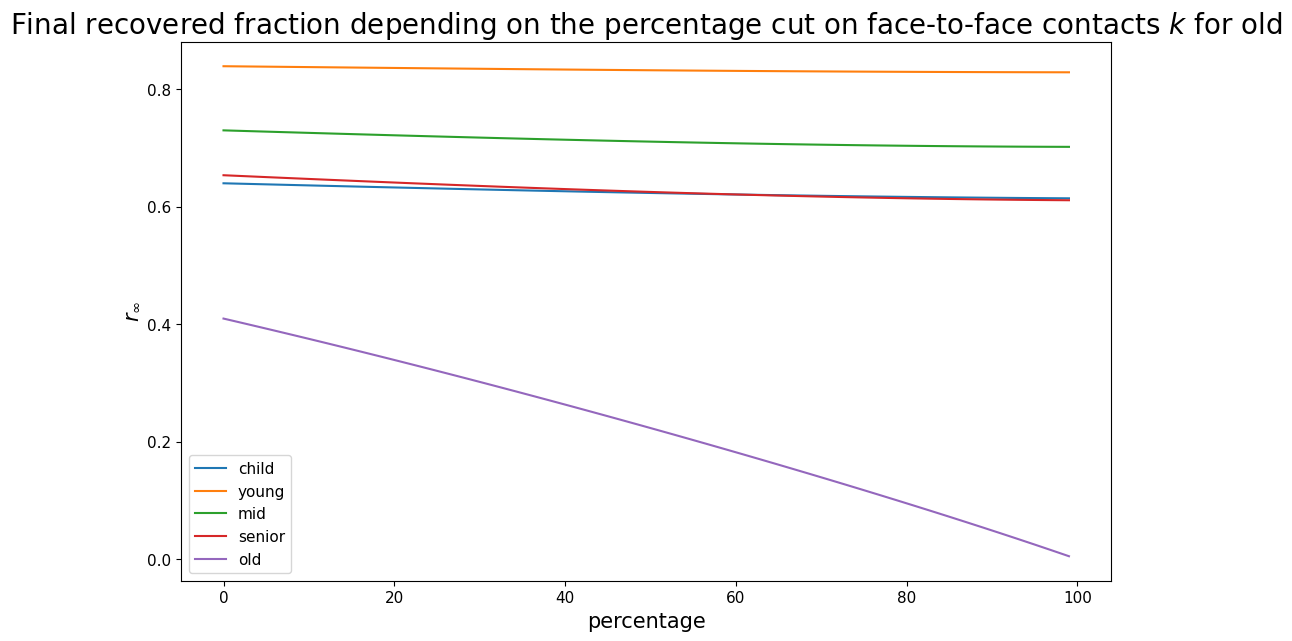

In [22]:
perc_ = 100-mod_*100

plt.plot(perc_, zr[:,0], label = 'child')
plt.plot(perc_, zr[:,1], label = 'young')
plt.plot(perc_, zr[:,2], label = 'mid')
plt.plot(perc_, zr[:,3], label = 'senior')
plt.plot(perc_, zr[:,4], label = 'old')
plt.xlabel(r'percentage', fontsize = 15)
plt.ylabel(r'$r_{\infty}$', fontsize = 15)
plt.title(r'Final recovered fraction depending on the percentage cut on face-to-face contacts $k$ for old', fontsize = 20)
#plt.xlim(1,max_gamma)
plt.legend()

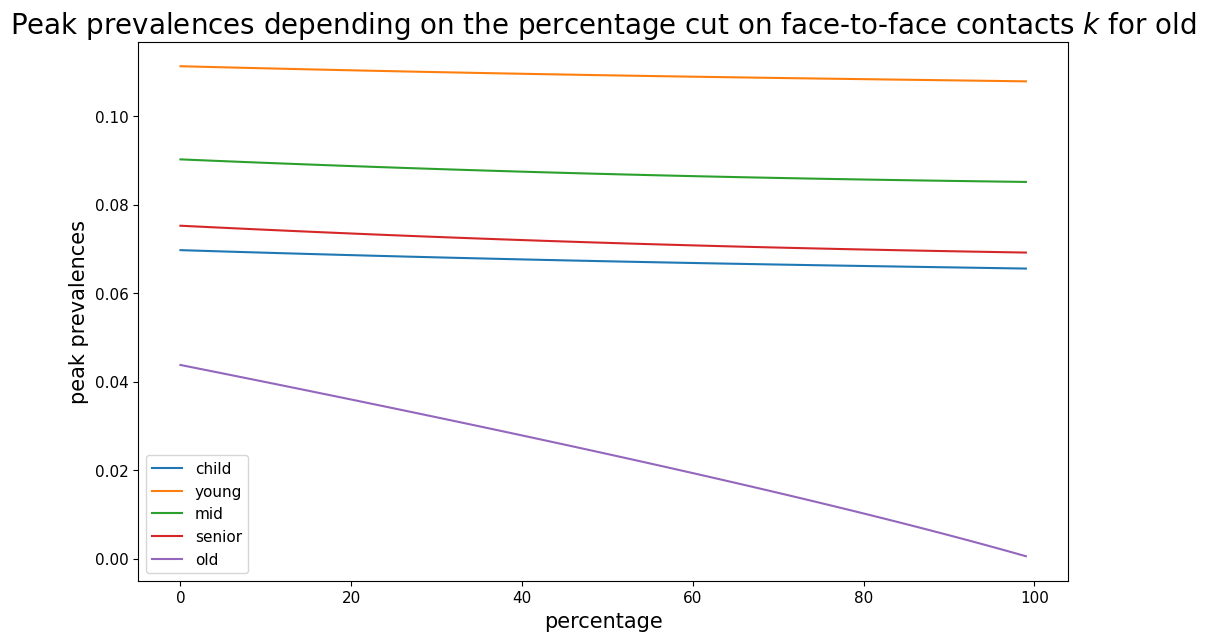

In [23]:
plt.plot(perc_, h_peak[:,0], label = 'child')
plt.plot(perc_, h_peak[:,1], label = 'young')
plt.plot(perc_, h_peak[:,2], label = 'mid')
plt.plot(perc_, h_peak[:,3], label = 'senior')
plt.plot(perc_, h_peak[:,4], label = 'old')
plt.xlabel(r'percentage', fontsize = 15)
plt.ylabel(r'peak prevalences', fontsize = 15)
plt.title(r'Peak prevalences depending on the percentage cut on face-to-face contacts $k$ for old', fontsize = 20)
#plt.xlim(1,max_gamma)
plt.legend()

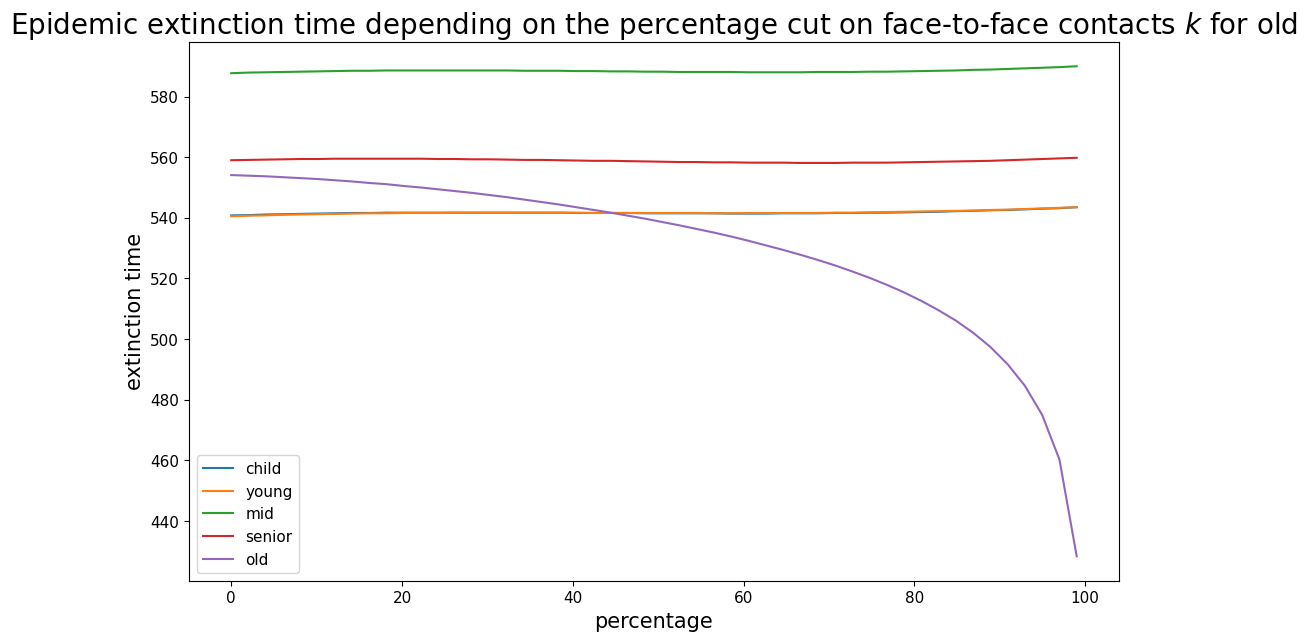

In [24]:
plt.plot(perc_, time_ext[:,0], label = 'child')
plt.plot(perc_, time_ext[:,1], label = 'young')
plt.plot(perc_, time_ext[:,2], label = 'mid')
plt.plot(perc_, time_ext[:,3], label = 'senior')
plt.plot(perc_, time_ext[:,4], label = 'old')
plt.xlabel(r'percentage', fontsize = 15)
plt.ylabel(r'extinction time', fontsize = 15)
plt.title(r'Epidemic extinction time depending on the percentage cut on face-to-face contacts $k$ for old', fontsize = 20)
#plt.xlim(1,max_gamma)
plt.legend()

## Analysis results

In [25]:
age = 4 #65+
T = 1000

#no interventions
flag = 1
mod = 1
no_int = deterministic_simulation(R_0, beta_F, r_b, mu, mu_F, alpha, gamma, R0, S_F0, I0, N_classes, T, k, M, T_switch, mod, flag)
y_no = [no_int[i][age][-1]/N_classes[age] for i in range(1,5)]

#intervention 1
flag = 1
mod = 1.8
int1 = deterministic_simulation(R_0, beta_F, r_b, mu, mu_F, alpha, gamma, R0, S_F0, I0, N_classes, T, k, M, T_switch, mod, flag)
y1 = [int1[i][age][-1]/N_classes[age] for i in range(1,5)]

#intervention 2
flag = 2
mod = 1.8
int2 = deterministic_simulation(R_0, beta_F, r_b, mu, mu_F, alpha, gamma, R0, S_F0, I0, N_classes, T, k, M, T_switch, mod, flag)
y2 = [int2[i][age][-1]/N_classes[age] for i in range(1,5)]

#intervention 3
flag = 3
mod = 1.8
int3 = deterministic_simulation(R_0, beta_F, r_b, mu, mu_F, alpha, gamma, R0, S_F0, I0, N_classes, T, k, M, T_switch, mod, flag)
y3 = [int3[i][age][-1]/N_classes[age] for i in range(1,5)]

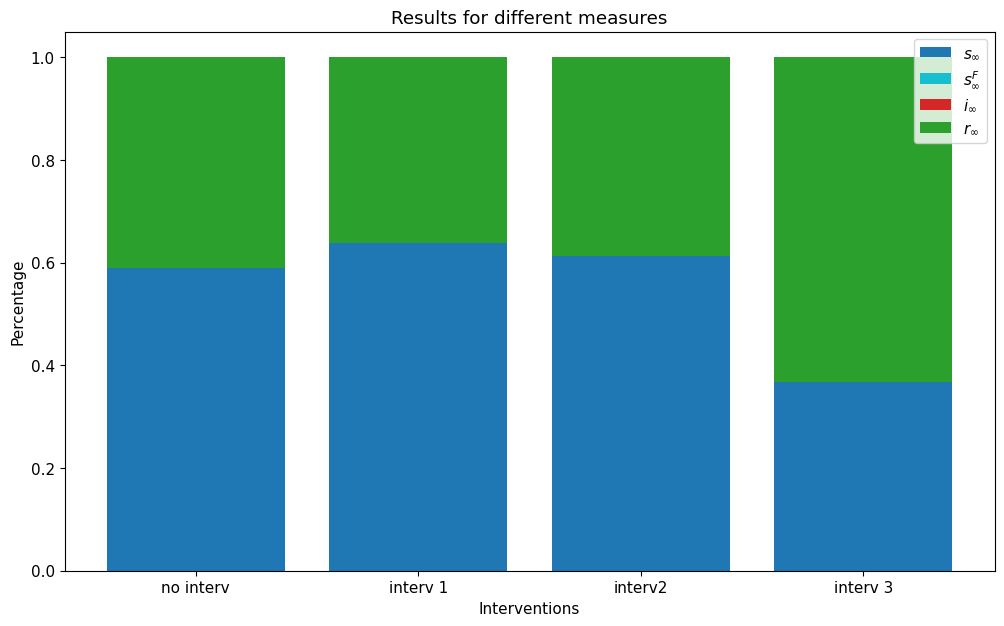

In [26]:
x = ['no interv', 'interv 1', 'interv2', 'interv 3']

s_inf = np.array([y_no[0], y1[0], y2[0], y3[0]])
sf_inf = np.array([y_no[1], y1[1], y2[1], y3[1]])
i_inf = np.array([y_no[2], y1[2], y2[2], y3[2]])
r_inf = np.array([y_no[3], y1[3], y2[3], y3[3]])
 
plt.bar(x, s_inf, color='tab:blue')
plt.bar(x, sf_inf, bottom=s_inf, color='tab:cyan')
plt.bar(x, i_inf, bottom=s_inf+sf_inf, color='tab:red')
plt.bar(x, r_inf, bottom=s_inf+sf_inf+i_inf, color='tab:green')
plt.xlabel("Interventions")
plt.ylabel("Percentage")
plt.legend(["$s_{\infty}$", "$s^F_{\infty}$", "$i_{\infty}$", "$r_{\infty}$"])
plt.title("Results for different measures")
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=51890446-0505-48b3-b3b7-32246abba1ea' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>